In [1]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        print(filename)
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [4]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [5]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


eindhoven15.csv_filled_.csv
eindhoven16.csv_filled_.csv
eindhoven17.csv_filled_.csv
eindhoven18.csv_filled_.csv
eindhoven19.csv_filled_.csv


In [6]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]

# Fill X and Y
X = np.zeros((len(overlapping1519), 5, 40))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()

for i, df in enumerate([df15, df16, df17, df18, df19]):
    X[:,i] = df[df.columns[:-3]].loc[overlapping1519]
    Y[:,i] = df.loc[overlapping1519]["y"]
    Y_1[:,i] = df.loc[overlapping1519]["y-1"]


In [7]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [8]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [9]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [10]:
# X train is the first three years
X_train = X[:,:3]

#fill X_train Y(t-1) with actual values for resampling
X_train[:,0,39] = Y1_15
X_train[:,1,39] = Y1_16
X_train[:,2,39] = Y1_17

X_train = X_train.reshape(-1, 40*3)


Y_train = Y[:,2]


In [11]:
# oversample X_train using SMOTE

smote = SMOTE()
X_train_resample,Y_train_resample = smote.fit_resample(X_train,Y_train)
X_train = X_train.reshape(-1,3,40)
X_train_resample = X_train_resample.reshape(-1,3,40)

# transform Y(t-1) to proper values

Y1_17r = X_train_resample[:,2,-1]
Y1_17r[Y1_17r>0.5] =  np.ceil(Y1_17r[Y1_17r > 0.5])

X_train_resample = np.delete(X_train_resample, -1, 2)
X_train = np.delete(X_train, -1, 2)

X_train = X_train.reshape(-1, 39)
X_train_resample = X_train_resample.reshape(-1, 39)

# Fit and transform the standard scaler
X_train = ss.fit_transform(X_train)
X_train_resample = ss.transform(X_train_resample)

X_train_resample = X_train_resample.reshape(-1,3, 39)

Y1_17r = torch.tensor(Y1_17r).float().to(device).to(device)
Y1_18 = torch.tensor(Y1_18).float().to(device).to(device)

In [12]:
# create X_val and X_test
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.delete(X_val, -1, 2)

X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(-1, 4, 39)



X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.delete(X_test, -1, 2)
X_test = X_test.reshape(-1, 39)

X_test = ss.transform(X_test)
X_test = X_test.reshape(-1, 5, 39)

X_val = torch.tensor(X_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)




In [13]:
Y_val = torch.tensor(Y_val).float().to(device)
X_train_resample = torch.tensor(X_train_resample).float().to(device)
Y_train_resample = torch.tensor(Y_train_resample).float().to(device)


In [14]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.GRU = nn.GRU(input_size = 39, dropout = 0.2,num_layers = 2,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        return X


In [15]:
class RNN1(nn.Module):
    def __init__(self):
        super(RNN1, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [16]:
class RNN2(nn.Module):
    def __init__(self):
        super(RNN2, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [17]:
class RNN3(nn.Module):
    def __init__(self):
        super(RNN3, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 2,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [18]:
class RNN4(nn.Module):
    def __init__(self):
        super(RNN4, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [19]:
class RNN5(nn.Module):
    def __init__(self):
        super(RNN5, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,150),
            nn.ReLU(),
            nn.Linear(150,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [20]:
model = RNN().to(device)
model1 = RNN1().to(device)
model2 = RNN2().to(device)
model3 = RNN3().to(device)
model4 = RNN4().to(device)
model5 = RNN5().to(device)

models = [0,1,2,3,4,5]

In [21]:
def train(models, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    
    for i, model in enumerate(models):
        for lr in [0.00000051, 0.0000051]:
#         for lr in [0.0000051]:
                
            if model == 0: model = RNN()         
            elif model ==1: model = RNN1()                
            elif model == 2: model = RNN2()
            elif model == 3: model = RNN3()
            elif model == 4: model = RNN4()
            else: model = RNN5()
           
            ROC_history = []     
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()
            
            for epoch in range(num_epochs):
                epoch_loss = []
#                 print("epoch: {} of {}".format(epoch, num_epochs))
                for batch in range(batch_per_e):

                    x, y, y1 = get_batch(X_train, Y_train, Y1_train, 6)

                    model.train()

                    optimizer.zero_grad()
                    out = model(x, y1).squeeze()


                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()


                    epoch_loss.append(loss.detach().numpy())

                model.eval()

                out = model(X_val, Y1_val)
                ROC = roc_auc_score(Y_val, model.final(out).detach().numpy())
                out = out.squeeze().detach().numpy()

                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1
                
                f1 = f1_score(Y_val, preds)

                ROC_history.append(ROC)

                if ROC > best_auc:
                    print("model: {}, ROC:{}, f1: {}, lr: {}, epoch = {}".format(i, ROC, f1, lr, epoch))
                    best_auc = ROC
                    best_f1 = f1
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_lr = lr

                train_loss = []
                          
            print(np.max(ROC_history), np.argmax(ROC_history), lr)
            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
            linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
            linear_model_fn=np.poly1d(linear_model)
            x_s=np.arange(0,n_epochs)
            plt.plot(linear_model_fn(x_s))  
            plt.show()
                          
    result = np.argmax(ROC_history)
    return best_auc, best_f1, best_model, best_epoch

model: 0, ROC:0.4992722743384478, f1: 0.10022271714922049, lr: 5.1e-07, epoch = 0
model: 0, ROC:0.5001259292326147, f1: 0.10022271714922049, lr: 5.1e-07, epoch = 1
model: 0, ROC:0.5010389161690714, f1: 0.10022271714922049, lr: 5.1e-07, epoch = 2
model: 0, ROC:0.5018838932475292, f1: 0.10244988864142539, lr: 5.1e-07, epoch = 3
model: 0, ROC:0.5024366499272275, f1: 0.10244988864142539, lr: 5.1e-07, epoch = 4
model: 0, ROC:0.5031696226401386, f1: 0.10022271714922049, lr: 5.1e-07, epoch = 5
model: 0, ROC:0.5040660611838478, f1: 0.10244988864142539, lr: 5.1e-07, epoch = 6
model: 0, ROC:0.5049372735191004, f1: 0.10244988864142539, lr: 5.1e-07, epoch = 7
model: 0, ROC:0.5057132316912215, f1: 0.10244988864142539, lr: 5.1e-07, epoch = 8
model: 0, ROC:0.5063965592258903, f1: 0.10244988864142539, lr: 5.1e-07, epoch = 9
model: 0, ROC:0.5071876531230853, f1: 0.10244988864142539, lr: 5.1e-07, epoch = 10
model: 0, ROC:0.50809135681483, f1: 0.10690423162583519, lr: 5.1e-07, epoch = 11
model: 0, ROC:0.

model: 0, ROC:0.5658105362405765, f1: 0.15367483296213807, lr: 5.1e-07, epoch = 100
model: 0, ROC:0.5662109266211975, f1: 0.15367483296213807, lr: 5.1e-07, epoch = 101
model: 0, ROC:0.5666781160018114, f1: 0.155902004454343, lr: 5.1e-07, epoch = 102
model: 0, ROC:0.5669862793643158, f1: 0.155902004454343, lr: 5.1e-07, epoch = 103
model: 0, ROC:0.5674373239715174, f1: 0.155902004454343, lr: 5.1e-07, epoch = 104
model: 0, ROC:0.5678558772222272, f1: 0.155902004454343, lr: 5.1e-07, epoch = 105
model: 0, ROC:0.5682247852946946, f1: 0.155902004454343, lr: 5.1e-07, epoch = 106
model: 0, ROC:0.5686457602614161, f1: 0.155902004454343, lr: 5.1e-07, epoch = 107
model: 0, ROC:0.5691747034003314, f1: 0.155902004454343, lr: 5.1e-07, epoch = 108
model: 0, ROC:0.5695375571827694, f1: 0.155902004454343, lr: 5.1e-07, epoch = 109
model: 0, ROC:0.569876193805089, f1: 0.155902004454343, lr: 5.1e-07, epoch = 110
model: 0, ROC:0.5703326872733173, f1: 0.155902004454343, lr: 5.1e-07, epoch = 111
model: 0, ROC

model: 0, ROC:0.5958180193430531, f1: 0.18485523385300667, lr: 5.1e-07, epoch = 199
model: 0, ROC:0.5960634198989175, f1: 0.18708240534521162, lr: 5.1e-07, epoch = 200
model: 0, ROC:0.5962204278203507, f1: 0.18708240534521162, lr: 5.1e-07, epoch = 201
model: 0, ROC:0.5965154735544576, f1: 0.18708240534521162, lr: 5.1e-07, epoch = 202
model: 0, ROC:0.5966660235665258, f1: 0.18708240534521162, lr: 5.1e-07, epoch = 203
model: 0, ROC:0.5968603662764744, f1: 0.18930957683741648, lr: 5.1e-07, epoch = 204
model: 0, ROC:0.597077917098203, f1: 0.18930957683741648, lr: 5.1e-07, epoch = 205
model: 0, ROC:0.5972431992160098, f1: 0.18708240534521162, lr: 5.1e-07, epoch = 206
model: 0, ROC:0.5974611536570738, f1: 0.18930957683741648, lr: 5.1e-07, epoch = 207
model: 0, ROC:0.5976496438866605, f1: 0.18930957683741648, lr: 5.1e-07, epoch = 208
model: 0, ROC:0.5978912100588396, f1: 0.1915367483296214, lr: 5.1e-07, epoch = 209
model: 0, ROC:0.5981093663095711, f1: 0.1915367483296214, lr: 5.1e-07, epoch =

model: 0, ROC:0.6124142409817314, f1: 0.20044543429844097, lr: 5.1e-07, epoch = 297
model: 0, ROC:0.6125841647218941, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 298
model: 0, ROC:0.6127599409424188, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 299
model: 0, ROC:0.6128640747309272, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 300
model: 0, ROC:0.6130162392203367, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 301
model: 0, ROC:0.613164972945396, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 302
model: 0, ROC:0.6133393364982471, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 303
model: 0, ROC:0.6134479100994438, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 304
model: 0, ROC:0.6136426564287276, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 305
model: 0, ROC:0.6138174236009141, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 306
model: 0, ROC:0.6139370967338316, f1: 0.19821826280623608, lr: 5.1e-07, epoch = 307
model: 0, ROC:0.6140985444679531, f1: 0.19821826280623608, lr: 5.1e-07, epoch

model: 0, ROC:0.6251062527900187, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 396
model: 0, ROC:0.6252041304788297, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 397
model: 0, ROC:0.6252939357809348, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 398
model: 0, ROC:0.6253827320347015, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 399
model: 0, ROC:0.6254789952461715, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 400
model: 0, ROC:0.6255645625452558, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 401
model: 0, ROC:0.6256481117476637, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 402
model: 0, ROC:0.6257381188594363, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 403
model: 0, ROC:0.6258236861585207, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 404
model: 0, ROC:0.6258918978261869, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 405
model: 0, ROC:0.6259877574183216, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 406
model: 0, ROC:0.6260618215663498, f1: 0.21158129175946547, lr: 5.1e-07, epoc

model: 0, ROC:0.6319187417409393, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 494
model: 0, ROC:0.6319895769342851, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 495
model: 0, ROC:0.6320628338436428, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 496
model: 0, ROC:0.6321247894116118, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 497
model: 0, ROC:0.6321752418285248, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 498
model: 0, ROC:0.6322285195807847, f1: 0.21158129175946547, lr: 5.1e-07, epoch = 499
0.6322285195807847 499 5.1e-07


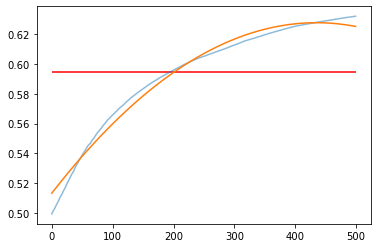

model: 0, ROC:0.6382638395015785, f1: 0.22494432071269488, lr: 5.1e-06, epoch = 4
model: 0, ROC:0.6415279090661782, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 5
model: 0, ROC:0.6445952142048175, f1: 0.2383073496659243, lr: 5.1e-06, epoch = 6
model: 0, ROC:0.646258731295271, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 7
model: 0, ROC:0.6477020740383165, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 8
model: 0, ROC:0.6490554096695892, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 9
model: 0, ROC:0.6503538530712605, f1: 0.24721603563474387, lr: 5.1e-06, epoch = 10
model: 0, ROC:0.6519275648596091, f1: 0.24721603563474387, lr: 5.1e-06, epoch = 11
model: 0, ROC:0.6532663701948109, f1: 0.24498886414253898, lr: 5.1e-06, epoch = 12
model: 0, ROC:0.6552122190103092, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 13
model: 0, ROC:0.6561988664754588, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 14
model: 0, ROC:0.6571859175599436, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 15
model: 0, RO

model: 0, ROC:0.6841299299074662, f1: 0.26057906458797325, lr: 5.1e-06, epoch = 105
model: 0, ROC:0.6841658520283083, f1: 0.26057906458797325, lr: 5.1e-06, epoch = 106
model: 0, ROC:0.6844384968893058, f1: 0.26057906458797325, lr: 5.1e-06, epoch = 107
model: 0, ROC:0.6845002506476072, f1: 0.26057906458797325, lr: 5.1e-06, epoch = 108
model: 0, ROC:0.6846740087714555, f1: 0.26057906458797325, lr: 5.1e-06, epoch = 109
model: 0, ROC:0.6848798546324603, f1: 0.26057906458797325, lr: 5.1e-06, epoch = 111
model: 0, ROC:0.6849841902306362, f1: 0.26057906458797325, lr: 5.1e-06, epoch = 112
model: 0, ROC:0.6852558260432954, f1: 0.26280623608017817, lr: 5.1e-06, epoch = 113
model: 0, ROC:0.6853597580221361, f1: 0.26280623608017817, lr: 5.1e-06, epoch = 117
model: 0, ROC:0.6854535995175942, f1: 0.26280623608017817, lr: 5.1e-06, epoch = 118
model: 0, ROC:0.6855920409496032, f1: 0.26280623608017817, lr: 5.1e-06, epoch = 119
model: 0, ROC:0.6858291673090942, f1: 0.26280623608017817, lr: 5.1e-06, epoc

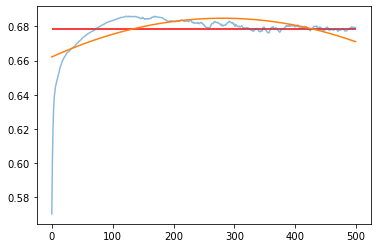

0.6370939488582011 499 5.1e-07


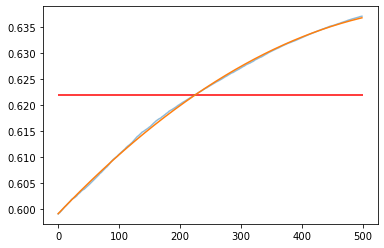

model: 1, ROC:0.6860378385054461, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 96
model: 1, ROC:0.6861528700160076, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 97
model: 1, ROC:0.6862798082969604, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 99
model: 1, ROC:0.6863811167501217, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 100
model: 1, ROC:0.6866977561186673, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 101
model: 1, ROC:0.6869964344267919, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 102
model: 1, ROC:0.6870329619766369, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 103
model: 1, ROC:0.6871080351730033, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 104
model: 1, ROC:0.6873966229977453, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 105
model: 1, ROC:0.6874601930430557, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 106
model: 1, ROC:0.6874777504841414, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 107
model: 1, ROC:0.6876509031789866, f1: 0.24053452115812918, lr: 5.1e-06, epoch =

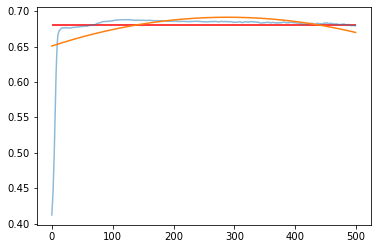

0.6818182001645152 499 5.1e-07


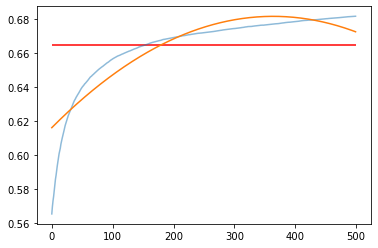

0.6844370842216322 412 5.1e-06


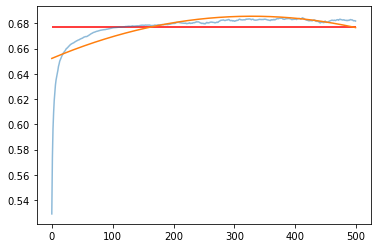

0.6736723547394194 499 5.1e-07


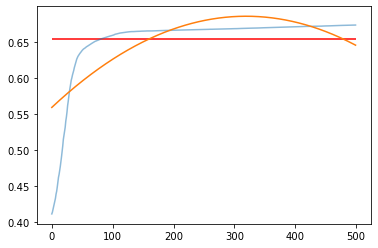

0.681284009974241 447 5.1e-06


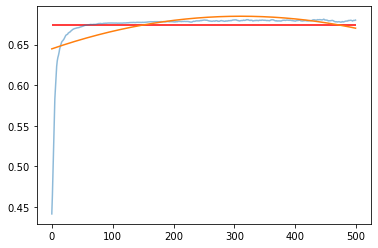

0.6655158134019379 499 5.1e-07


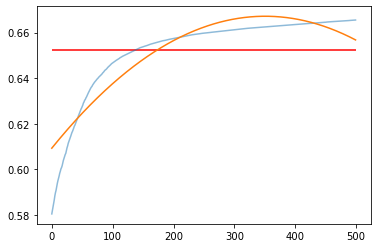

0.6873047995989637 449 5.1e-06


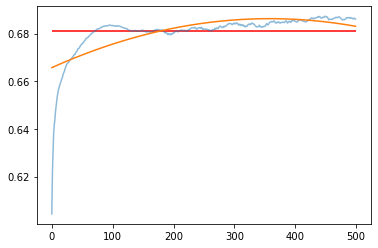

0.6637982113205537 499 5.1e-07


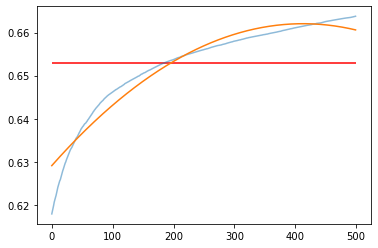

0.6792233314578489 136 5.1e-06


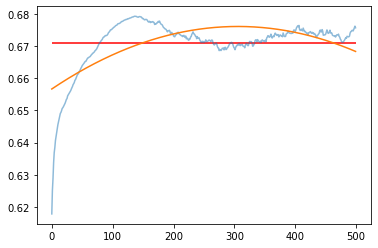

In [22]:
n_epochs = 500
hists = train(models, X_train_resample, Y_train_resample, Y1_17r, X_val, Y_val, Y1_18, n_epochs, 0.0000051)

In [30]:
hists

(0.6921353158038765,
 0.26280623608017817,
 OrderedDict([('GRU.weight_ih_l0',
               tensor([[-0.1359, -0.0654, -0.1440,  ...,  0.0144,  0.0971,  0.0889],
                       [ 0.0362,  0.0550, -0.1206,  ...,  0.1302,  0.0385, -0.1203],
                       [-0.1320, -0.1318, -0.0334,  ...,  0.1284,  0.1104,  0.0710],
                       ...,
                       [-0.0325, -0.0083,  0.0075,  ...,  0.1066,  0.0579, -0.0831],
                       [-0.0108,  0.0577, -0.0990,  ...,  0.1044, -0.0554,  0.0100],
                       [-0.0902, -0.1359,  0.0275,  ...,  0.1352,  0.1155,  0.0139]])),
              ('GRU.weight_hh_l0',
               tensor([[ 0.1526, -0.0824, -0.0390,  ..., -0.0541, -0.0606, -0.0125],
                       [-0.0747,  0.0436,  0.1129,  ..., -0.0578,  0.0533,  0.0272],
                       [ 0.0212,  0.0651,  0.0497,  ..., -0.0041, -0.0258,  0.0664],
                       ...,
                       [-0.0481,  0.0528,  0.0061,  ...,  0.055

best model: model 2, auc = 0.(0.7132703366008875,

f1: 0.3506410256410256,, lr =  5.1e-06

In [23]:
model = RNN5()
model.load_state_dict(hists[2])
model.eval()

out = model(X_test, torch.tensor(Y1_19))

ROC = roc_auc_score(Y_test, model.final(out).detach().numpy())
out = out.squeeze().detach().numpy()

preds = np.zeros(len(out))
pos = out.argsort()[-((Y_test == 1).sum()):]
preds[pos] = 1

f1 = f1_score(Y_test, preds)
print(ROC, f1)
with open ("../Results/Eindhoven.csv", "a+") as f:
    f.write("\nRNN,{},{}".format(ROC,f1))

0.6896924310586189 0.23809523809523808


0.6110970206754848 178


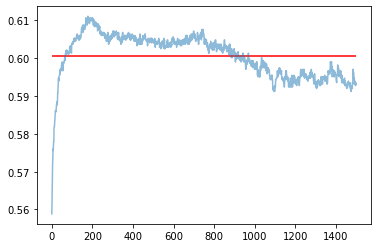

In [72]:
print(np.max(hists[-4]), np.argmax(hists[-4]))
plt.plot(hists[-4], alpha = 0.5)
plt.hlines(np.mean(hists[-4]), 0, n_epochs, color = "r")